In [1]:
import torch
import torch.autograd.functional as F
import torch.distributions as dist

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

In [27]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())
#plt.rcParams.update(bundles.icml2022())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'


In [3]:
try:
    import hamiltorch
except ImportError:
    %pip install git+https://github.com/AdamCobb/hamiltorch


In [4]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [59]:
device

device(type='cuda')

In [28]:
gt_distribution = torch.distributions.Normal(0, 1)

# Samples from the ground truth distribution
def sample_gt(n):
    return gt_distribution.sample((n,))

samples = sample_gt(1000)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed


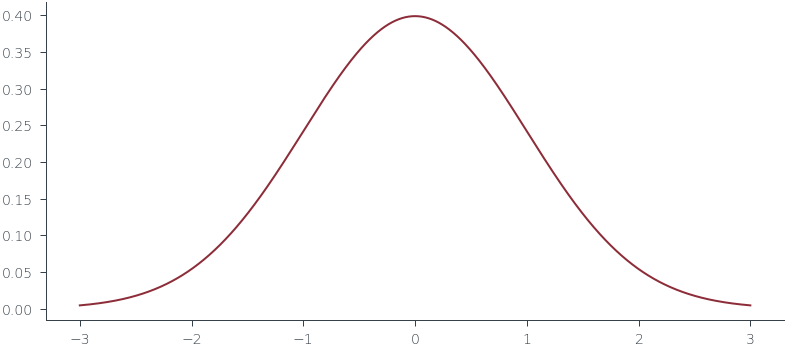

In [29]:
x_lin = torch.linspace(-3, 3, 1000)
y_lin = torch.exp(gt_distribution.log_prob(x_lin))

plt.plot(x_lin, y_lin, label='Ground truth')


In [73]:
# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return gt_distribution.log_prob(x).sum()

# Initial state
x0 = torch.tensor([0.0])
num_samples = 5000
step_size = 0.3
num_steps_per_sample = 5
hamiltorch.set_random_seed(123)

In [74]:
isinstance(hamiltorch, torch.nn.Module)

False

In [75]:
params_hmc = hamiltorch.sample(log_prob_func=logprob, params_init=x0,  
                               num_samples=num_samples, step_size=step_size, 
                               num_steps_per_sample=num_steps_per_sample)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:08 | 0d:00:00:00 | #################### | 5000/5000 | 620.20       
Acceptance Rate 0.99


In [69]:
params_hmc

[tensor([0.], device='cuda:0'),
 tensor([0.1523], device='cuda:0'),
 tensor([1.9027], device='cuda:0'),
 tensor([1.5952], device='cuda:0'),
 tensor([0.6811], device='cuda:0'),
 tensor([-1.2811], device='cuda:0'),
 tensor([-2.4834], device='cuda:0'),
 tensor([1.1204], device='cuda:0'),
 tensor([1.2537], device='cuda:0'),
 tensor([1.0104], device='cuda:0'),
 tensor([2.6508], device='cuda:0'),
 tensor([0.7549], device='cuda:0'),
 tensor([0.2470], device='cuda:0'),
 tensor([-0.9422], device='cuda:0'),
 tensor([-0.6397], device='cuda:0'),
 tensor([0.8129], device='cuda:0'),
 tensor([1.6215], device='cuda:0'),
 tensor([1.0760], device='cuda:0'),
 tensor([-0.0599], device='cuda:0'),
 tensor([1.0623], device='cuda:0'),
 tensor([0.8488], device='cuda:0'),
 tensor([0.7382], device='cuda:0'),
 tensor([1.1924], device='cuda:0'),
 tensor([0.1206], device='cuda:0'),
 tensor([-0.0937], device='cuda:0'),
 tensor([-0.6839], device='cuda:0'),
 tensor([1.3677], device='cuda:0'),
 tensor([-2.0525], device

In [32]:
params_hmc = torch.tensor(params_hmc)

Text(0, 0.5, 'Parameter value')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed


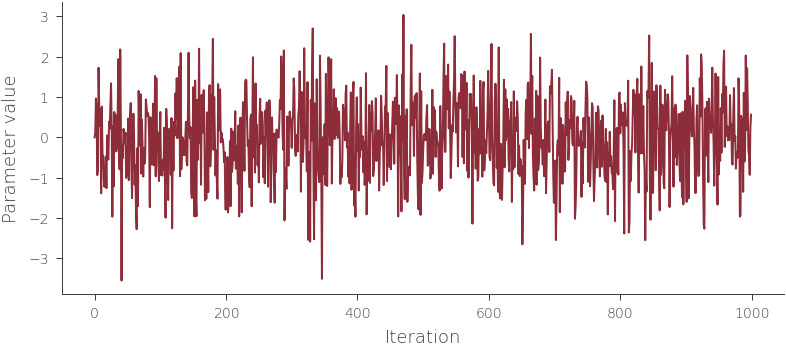

In [33]:
# Trace plot
plt.plot(params_hmc, label='Trace')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')

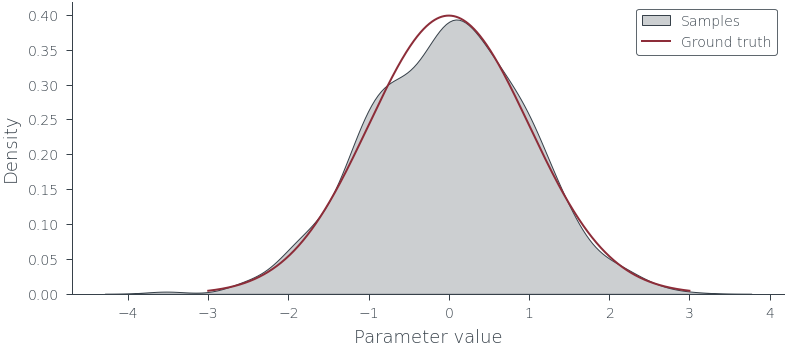

In [34]:
# KDE plot
import seaborn as sns
plt.figure()
sns.kdeplot(params_hmc.detach().numpy(), label='Samples', shade=True, color='C1')
plt.plot(x_lin, y_lin, label='Ground truth')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.legend()

Text(0, 0.5, 'y')

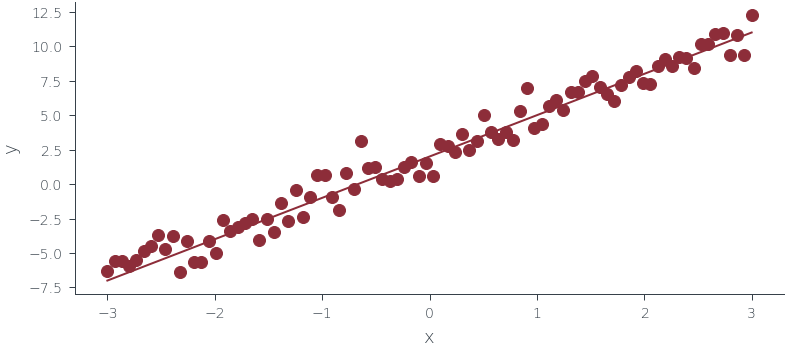

In [141]:
# Linear regression for 1 dimensional input using HMC

x_lin = torch.linspace(-3, 3, 90)
theta_0_true = torch.tensor([2.0])
theta_1_true = torch.tensor([3.0])
f = lambda x: theta_0_true + theta_1_true * x
eps = torch.randn_like(x_lin) *1.0
y_lin = f(x_lin) + eps

plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.plot(x_lin, f(x_lin), label='Ground truth')
plt.xlabel('x')
plt.ylabel('y')

In [142]:
# Case 1: Fixed noise variance to 1
def logprob(theta):
    y_pred = theta[0] + x_lin * theta[1]
    return dist.Normal(y_pred, 1).log_prob(y_lin).sum()

def log_prior(theta):
    return dist.Normal(0, 1).log_prob(theta).sum()

def log_posterior(theta):
    return logprob(theta) + log_prior(theta)

In [157]:
# Initial state
theta_0_init = torch.tensor([-2.0])
theta_1_init = torch.tensor([2.0])
x0 = torch.cat([theta_0_init, theta_1_init])
num_samples = 50

params_hmc = hamiltorch.sample(log_prob_func=log_posterior, params_init=x0,
                                 num_samples=num_samples, step_size=0.1,
                                    num_steps_per_sample=5)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 50/50 | 261.83       
Acceptance Rate 0.84


In [158]:
params_hmc = torch.stack(params_hmc)

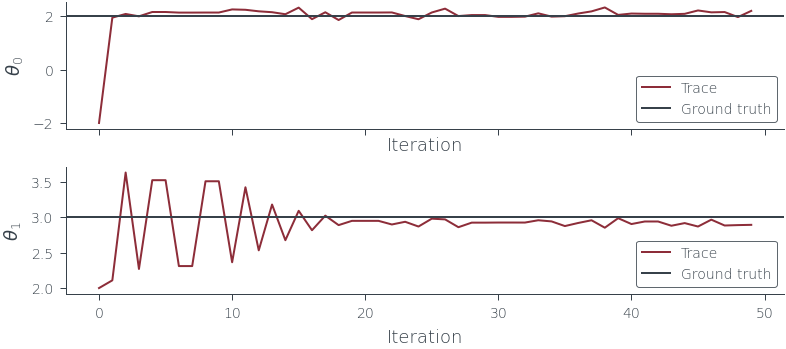

In [159]:
# Plot the traces corresponding to the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    axes[i].plot(param_vals, label='Trace')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel(fr'$\theta_{i}$')

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true]):
    axes[i].axhline(param_vals.numpy(), color='C1', label='Ground truth')
    axes[i].legend()

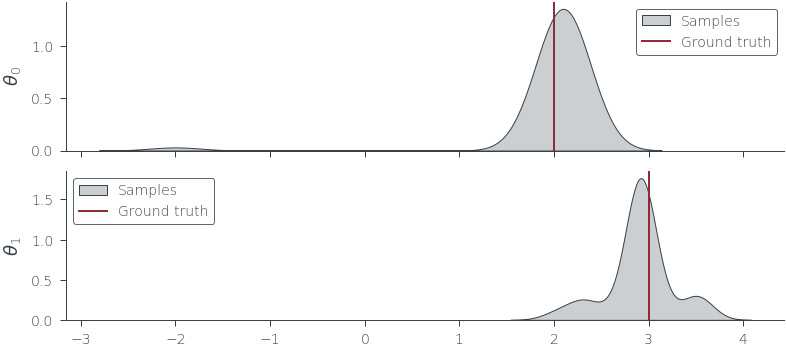

In [160]:
# Plot KDE of the samples for the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    sns.kdeplot(param_vals.detach().numpy(), label='Samples', shade=True, color='C1', ax=axes[i])
    axes[i].set_ylabel(fr'$\theta_{i}$')

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true]):
    axes[i].axvline(param_vals.numpy(), color='C0', label='Ground truth')
    axes[i].legend()

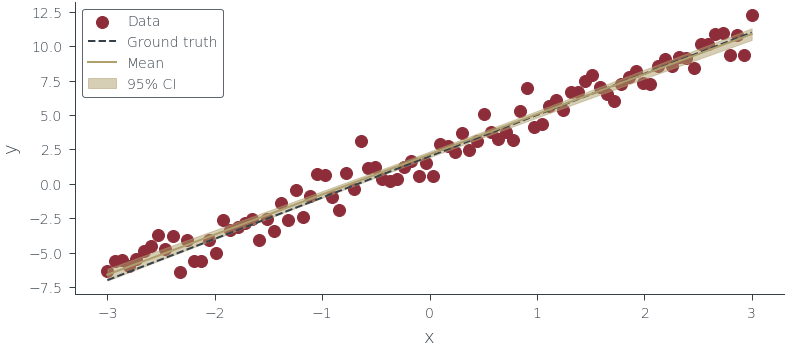

In [147]:
# Plot the posterior predictive distribution
plt.figure()
plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.plot(x_lin, f(x_lin), label='Ground truth', color='C1', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')

# Get posterior samples. Thin first 100 samples to remove burn-in
posterior_samples = params_hmc[100:]
y_hat = posterior_samples[:, 0].unsqueeze(1) + x_lin * posterior_samples[:, 1].unsqueeze(1)

# Plot mean and 95% confidence interval

plt.plot(x_lin, y_hat.mean(axis=0), label='Mean', color='C2')
plt.fill_between(x_lin, y_hat.mean(axis=0) - 2 * y_hat.std(axis=0), y_hat.mean(axis=0) + 2 * y_hat.std(axis=0), alpha=0.5, label='95% CI', color='C2')
plt.legend()

In [125]:
# Learn the noise variance as well
def logprob(theta):
    intercept, slope, log_noise = theta
    y_pred = intercept + x_lin * slope
    return dist.Normal(y_pred, torch.exp(log_noise)).log_prob(y_lin).sum()

# Initial state
theta_0_init = torch.tensor([-2.0])
theta_1_init = torch.tensor([2.0])
log_noise_init = torch.tensor([0.1])

x0 = torch.cat([theta_0_init, theta_1_init, log_noise_init])
num_samples = 5000

params_hmc = hamiltorch.sample(log_prob_func=logprob, params_init=x0,
                                    num_samples=num_samples, step_size=0.1,
                                    num_steps_per_sample=5)

params_hmc = torch.stack(params_hmc)



Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:14 | 0d:00:00:00 | #################### | 5000/5000 | 349.16       
Acceptance Rate 0.95


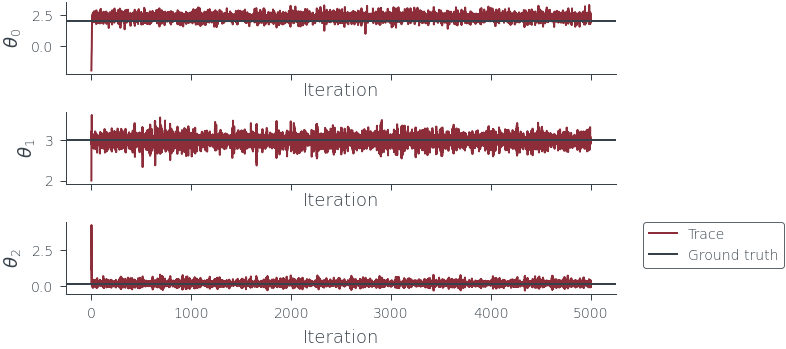

In [128]:
# Plot the traces corresponding to the three parameters
fig, axes = plt.subplots(3, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    axes[i].plot(param_vals, label='Trace')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel(fr'$\theta_{i}$')

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true, torch.log(eps.std())]):
    axes[i].axhline(param_vals.numpy(), color='C1', label='Ground truth')

# legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


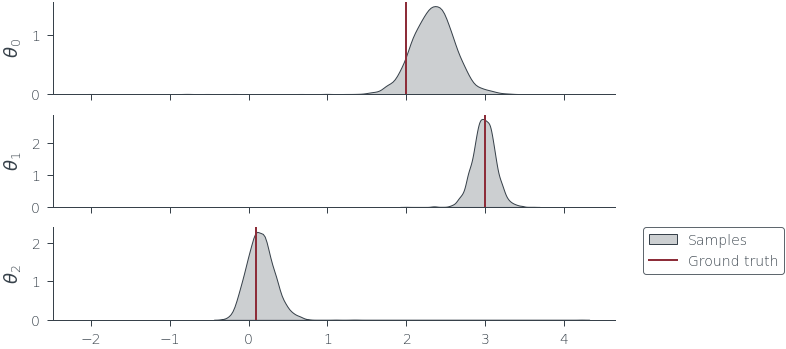

In [129]:
# Plot KDE of the samples for the three parameters
fig, axes = plt.subplots(3, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    sns.kdeplot(param_vals.detach().numpy(), label='Samples', shade=True, color='C1', ax=axes[i])
    axes[i].set_ylabel(fr'$\theta_{i}$')

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true, torch.log(eps.std())]):
    axes[i].axvline(param_vals.numpy(), color='C0', label='Ground truth')

# legend outside the plot   
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

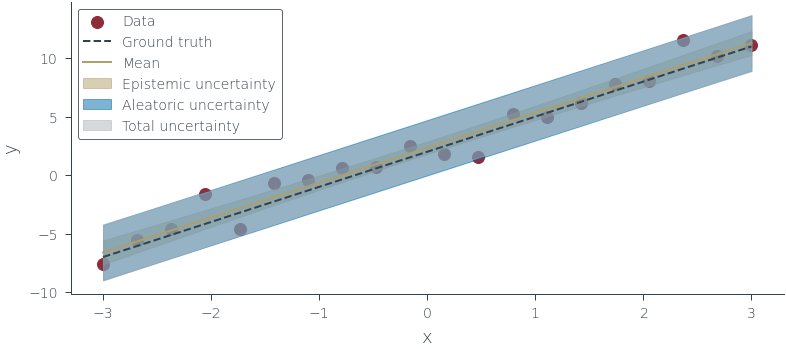

In [134]:
# Plot the posterior predictive distribution
plt.figure()
plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.plot(x_lin, f(x_lin), label='Ground truth', color='C1', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')

# Get posterior samples. Thin first 100 samples to remove burn-in
posterior_samples = params_hmc[100:]
y_hat = posterior_samples[:, 0].unsqueeze(1) + x_lin * posterior_samples[:, 1].unsqueeze(1)

# Plot mean and 95% confidence interval
plt.plot(x_lin, y_hat.mean(axis=0), label='Mean', color='C2')
plt.fill_between(x_lin, y_hat.mean(axis=0) - 2 * y_hat.std(axis=0), y_hat.mean(axis=0) + 2 * y_hat.std(axis=0), 
                 alpha=0.5, label='Epistemic uncertainty', color='C2')

# Plot aleatoric uncertainty
plt.fill_between(x_lin, y_hat.mean(axis=0) - 2 * torch.exp(posterior_samples[:, 2]).mean(axis=0),
                    y_hat.mean(axis=0) + 2 * torch.exp(posterior_samples[:, 2]).mean(axis=0),
                    alpha=0.5, label='Aleatoric uncertainty', color='C3')

# Plot total uncertainty
plt.fill_between(x_lin, y_hat.mean(axis=0) - 2 * torch.sqrt(torch.exp(posterior_samples[:, 2]).mean(axis=0) + y_hat.std(axis=0)**2),
                    y_hat.mean(axis=0) + 2 * torch.sqrt(torch.exp(posterior_samples[:, 2]).mean(axis=0) + y_hat.std(axis=0)**2),
                    alpha=0.5, label='Total uncertainty', color='C4')



plt.legend()

In [164]:
# Simple BNN in Hamiltorch
import torch.nn as nn


# Define the model
class BNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(BNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x
    

In [165]:
net = BNN(input_dim=1, output_dim=1, hidden_dim=10)
net

BNN(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)

In [166]:
net(torch.tensor([1.0]))

tensor([0.1153], grad_fn=<AddBackward0>)